In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
train_labels = pd.read_csv('../../data/TPSnov22/train_labels.csv', index_col=0)
train_labels.label.value_counts(True)

0    0.5
1    0.5
Name: label, dtype: float64

In [4]:
#import some lib
import pandas as pd
import numpy as np
import scipy.special

import seaborn as sns
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
# import path
import pathlib

from colorama import Fore, Back, Style

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

In [5]:
%%time
READ_FROM_CSV = False
if READ_FROM_CSV:
    predictions_files = []
    path = '../../data/TPSnov22/submission_files'

    for file in os.listdir(path):
        prediction = pd.read_csv(
            os.path.join(path, file),
            index_col=0,
            dtype={'id':np.int32, 'pred':np.float64}
        ) 

        prediction.columns = [file]
        predictions_files.append(prediction)

    preds_df = pd.concat(predictions_files, axis=1)
    preds_df.to_parquet('../../data/TPSnov22/preds_concat.parquet', compression='gzip')
else:
    preds_df = pd.read_parquet(
        '../../data/TPSnov22/tps_nov_df.parquet'
    )

CPU times: total: 1min 41s
Wall time: 2min 12s


In [6]:
preds_df

,0.6222863195.csv,0.6223807245.csv,0.6225426578.csv,0.6247722291.csv,0.6253455681.csv,0.6254850917.csv,0.6255093621.csv,0.6260141578.csv,0.6263493693.csv,0.6272779211.csv,...,0.7519100517.csv,0.7519556278.csv,0.7520219713.csv,0.7521219579.csv,0.7522329272.csv,0.7523602310.csv,0.7526089604.csv,0.7526999358.csv,0.7551167673.csv,0.7575039918.csv
id,,,,,,,,,,,,,,,,,,,,,
0,0.709336,0.799007,0.851891,0.537158,0.623930,0.705970,0.503437,0.633185,0.641550,0.666604,...,0.769207,0.750250,0.663370,0.739333,0.822384,0.749498,0.729800,0.867847,0.745888,0.787
1,0.452988,0.364453,0.567582,0.354468,0.513818,0.584119,0.454809,0.238501,0.472171,0.522314,...,0.640052,0.794052,0.721298,0.804369,0.620626,0.733606,0.816942,0.814229,0.598331,0.547
2,0.675462,0.842260,0.800013,0.525229,0.692071,0.715418,0.651008,0.609124,0.691198,0.609994,...,0.812841,0.779859,0.865657,0.828493,0.763010,0.802883,0.806891,0.896058,0.855776,0.667
3,0.481046,0.577118,0.683032,0.541356,0.630088,0.664514,0.413373,0.508210,0.526140,0.584565,...,0.824703,0.799698,0.800130,0.716604,0.603779,0.708499,0.844837,0.853057,0.850657,0.622
4,0.957339,0.910337,0.917322,0.874487,0.787595,0.854273,0.843846,0.876749,0.821128,0.913054,...,0.934803,0.900150,0.960911,0.906037,0.961240,0.935608,0.889757,0.978505,0.953681,0.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.382515,0.288985,0.483297,0.281330,0.414223,0.463336,0.390367,0.229408,0.455481,0.323629,...,0.561950,0.654353,0.614568,0.606837,0.474038,0.578634,0.584544,0.542198,0.542056,0.266
39996,0.352498,0.300423,0.594827,0.345519,0.488960,0.506300,0.216482,0.291425,0.471500,0.315838,...,0.584715,0.620182,0.635899,0.584809,0.677014,0.617092,0.607261,0.577821,0.589929,0.725
39997,0.577554,0.673746,0.760426,0.483366,0.682265,0.663974,0.448841,0.537298,0.575501,0.606992,...,0.739480,0.760507,0.774452,0.817324,0.802529,0.815348,0.712255,0.864388,0.786978,0.572


In [15]:
# preds_df = preds_df.clip(0.001, 0.999)
# copying train rows
preds_df['target'] = train_labels.label
train_preds = preds_df[preds_df.target.notnull()].copy()

# Feature engineering 

### original model

loss calculation

In [16]:
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
aucs = {}
log_losses = {}
brier_losses = {}

for c in tqdm(train_preds.columns):
    aucs[c] = roc_auc_score(train_preds.target, train_preds[c])
    log_losses[c] = log_loss(train_preds.target, train_preds[c])
#     brier_losses[c] = brier_score_loss(train_preds.target, train_preds[c])
    
auc_df = pd.DataFrame.from_dict(aucs, orient='index').squeeze().rename('AUC')
logloss_df = pd.DataFrame.from_dict(log_losses, orient='index').squeeze().rename('LogLoss')
# brierloss_df = pd.DataFrame.from_dict(brier_losses, orient='index').squeeze().rename('BrierLoss')
metrics_df= pd.concat([logloss_df, auc_df], axis=1)

100%|██████████| 5001/5001 [00:36<00:00, 137.85it/s]


In [24]:
metrics_df

,LogLoss,AUC
0.6222863195.csv,6.222863e-01,0.739764
0.6223807245.csv,6.223807e-01,0.756411
0.6225426578.csv,6.225427e-01,0.792846
0.6247722291.csv,6.247722e-01,0.735282
0.6253455681.csv,6.253456e-01,0.755193
...,...,...
0.7526089604.csv,7.526090e-01,0.704763
0.7526999358.csv,7.526999e-01,0.763297
0.7551167673.csv,7.551168e-01,0.747143
0.7575039918.csv,7.575040e-01,0.667346


<AxesSubplot:xlabel='LogLoss', ylabel='AUC'>

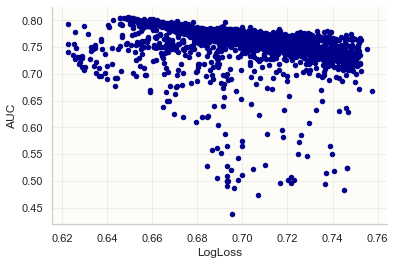

In [23]:
toplot = metrics_df[metrics_df.AUC.lt(1)]
toplot.plot.scatter(x='LogLoss',
                       y='AUC',
                       c='DarkBlue')

down-left model should be best, but auc and logloss seem to have neg correlation

### Calabrated Models

In [27]:
y_tr = train_preds.target
preds_df_calibrated = preds_df.copy()
for c in tqdm(train_preds.columns[:-1]):
    # finds calibrating delta
    X_tr=train_preds[c].values.clip(1e-6, 1-1e-6)
    def fun(x):
        return log_loss(y_tr, scipy.special.expit(scipy.special.logit(X_tr) - x))
    delta = scipy.optimize.minimize(fun, x0=1, method='Nelder-Mead', options={'maxiter': 2000})
    delta = delta.x[0]
    
    # fits calibration to all observations
    X_to_calibrate=preds_df[c].values.clip(1e-6, 1-1e-6)
    y_va_pred = scipy.special.expit(scipy.special.logit(X_to_calibrate) - delta)
    preds_df_calibrated[c] = y_va_pred  

100%|██████████| 5000/5000 [23:11<00:00,  3.59it/s]


In [41]:
train_preds.columns[-2]

'0.7575039918.csv'